# Defining a system of differential equations

When using PyGOM to study a compartmental model or series of ODEs, the starting point is to encapsulate the relevant information into a class {class}`.SimulateOde`.
Once defined as an instance of this class, the system is ready for the application of PyGOM's various features such as simulation and parameter fitting.

## Events and Transitions

If we are dealing with a compartmental model, the easiest way to define this is by feeding {class}`.Transition` and {class}`.Event` objects into the central class, {class}`.SimulateOde`.
We demonstrate how this is done via the example of an SIR model with some added features.

### Basic SIR model example

We first import the relevant modules:

In [1]:
from pygom import Event, Transition, SimulateOde

Next we specify the names of the states and parameters, which we can declare as lists.
Since we will most commonly be dealing with states which represent the counts of something, PyGOM will assume that the states are constrained to have a minimum value of zero and no upper bound.
If this is not the case, we can inform PyGOM about such limits by declaring the state as a tuple, with the first element being the state name and the second being another tuple containing the minimum and maximum allowed values.
We demonstrate below how this is done, even though in this case it's not necessary as we are specifying the default limits.

In [2]:
params=['beta', 'gamma', 'N']
states=[('S', (0, None)), ('I', (0, None)), ('R', (0, None))]
# equivalent to:
# states=['S', 'I', 'R']

Transitions are encapsulated in a {class}`.Transition` class.
We signify that a transition is between states by setting `transition_type`='T' and must also provide the origin and destination.
An {class}`.Event` object is then defined by the transition (or transitions) and the rate at which it occurs.

In [3]:
# 1) Infection
## Transition
transition_infection=Transition(origin='S', destination='I', transition_type='T', magnitude='1')
## Event
event_infection=Event(transition_list=[transition_infection], rate='beta*S*I/N')

# 2) Recovery
## Transition
transition_recovery=Transition(origin='I', destination='R', transition_type='T', magnitude='1')
## Event
event_recovery=Event(transition_list=[transition_recovery], rate='gamma*I')

We are now ready to initialise the model object:

In [4]:
model=SimulateOde(state=states, param=params, event=[event_infection, event_recovery])

We can check that the state change matrix (introduced as $\mathcal{D}$ {doc}`previously <solution>`), in which the columns correspond to events and the rows to the associated changes in the variables, is what we'd expect:

In [5]:
model.get_StateChangeMatrix()

Matrix([
[-1,  0],
[ 1, -1],
[ 0,  1]])

and we can also verify the event rate vector ($\boldsymbol{\lambda}$ from {doc}`before <solution>`) is correct:

In [6]:
model.get_EventRateVector()

Matrix([
[I*S*beta/N],
[   I*gamma]])

We can actually get away with a more shorthand approach in the model definition.
PyGOM assumes that the magnitude of a transition is 1 unless told otherwise, so there is no need to specify the `magnitude` argument here.
Also, both events only involve one transition each, so it's a bit cumbersome to always have to wrap a {class}`.Transition` within an {class}`.Event`.
A shorthand is to add the rate information to the {class}`.Transition`, this time as a parameter called `equation` and to feed the transitions in directly where we previously input the event list.

In [7]:
# 1) Infection
transition_infection=Transition(origin='S', destination='I', transition_type='T', equation='beta*S*I/N')

# 2) Recovery
transition_recovery=Transition(origin='I', destination='R', transition_type='T', equation='gamma*I')

# (states and params already defined in previous code cell)
model2=SimulateOde(state=states, param=params, event=[transition_infection, transition_recovery])

We briefly demonstrate that the end result is unchanged:

In [8]:
model2.get_StateChangeMatrix()

Matrix([
[-1,  0],
[ 1, -1],
[ 0,  1]])

In [9]:
model2.get_EventRateVector()

Matrix([
[I*S*beta/N],
[   I*gamma]])

When given a set of events and transitions, PyGOM can convert this into a set of ODEs:

In [10]:
model2.get_ode_eqn()

Matrix([
[          -I*S*beta/N],
[-I*gamma + I*S*beta/N],
[              I*gamma]])

and it can be helpful to verify visually that the model is defined as intended:

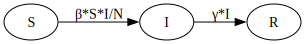

In [11]:
graph=model2.get_transition_graph(show=False)
graph

### More complex example

Let's now extend the above model so that it covers all of the aspects outlined in the {doc}`introduction to compartmental models <definition>`.
Firstly, let's introduce vital dynamics of birth and death.
The total population, $N$, will change if these rates are not balanced.
In fact, even if the rates are balanced, $N$ is subject to vary due to stochastic imbalances between births and deaths.
To track the potential evolution of this variable, we change $N$ from being a parameter to a state.

```{note}
Another way to allow $N$ to vary is to define it as a derived parameter by passing:

    derived_parameters=[('N', 'S+I+R')]

to {class}`.SimulateOde`

```

Birth and death {class}`.Transition` objects are indicated by `transition_type` B and D respectively and use `destination` and `origin` respectively to define the affected state.

We now show this in practice.
Whilst it is possible in PyGOM to build on previously existing models, when changing variable definitions we would recommend starting from scratch as we do here:

In [12]:
params=['beta', 'gamma', 'mu']          # now we have the birth rate parameter
states=['S', 'I', 'R', 'N']             # now we are treating the population count as a state

# Transitions in and out of total population count
# These will be used in the following event definitions
birth_N=Transition(destination="N", transition_type="B")
death_N=Transition(origin="N", transition_type="D")

# 1) Birth event into S
birth=Transition(destination="S", transition_type="B")
event_birth=Event(transition_list=[birth, birth_N], rate='mu*N')

# 2) Death event of an S
death_S=Transition(origin="S", transition_type="D")
event_death_S=Event(transition_list=[death_S, death_N], rate='mu*S')

# 3) Death event of an I
death_I=Transition(origin="I", transition_type="D")
event_death_I=Event(transition_list=[death_I, death_N], rate='mu*I')

# 4) Death event of an R
death_R=Transition(origin="R", transition_type="D")
event_death_R=Event(transition_list=[death_R, death_N], rate='mu*R')

model=SimulateOde(state=states, param=params, event=[event_infection,
                                                     event_recovery,
                                                     event_birth,
                                                     event_death_S,
                                                     event_death_I,
                                                     event_death_R])

As before, it's a good idea to check that the transition graph makes sense:

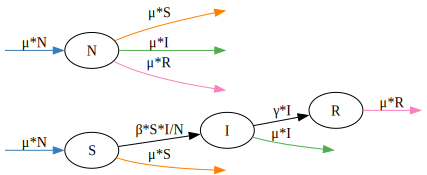

In [13]:
graph=model.get_transition_graph(show=False)
graph

Arrows in black represent transitions not correlated with any others.
Any non-black arrows which do share the same colour are correlated with each other and so are understood to change together when the underlying event occurs.
For example, the death of a recovered individual simultaneously decreases the $R$ and $N$ compartments by 1.

```{note}
Whilst the colour pallette we have used is ostensibly friendly to those with colour-blindness, we appreciate that there is room for improvement.
If the user has installed the package in editable mode, they may wish to substitute in their preferred pallette by changing the `cols` variable of the `_transition_graph` module.
```

Let's say we wish to replicate the {doc}`example <definition>` where we track the money spent, $M$, during the epidemic due to each infection event costing $c$ units.
We also track the cumulative infections in $Itot$.
This is implemented by adding these as {class}`.Transition` instances to the infection {class}`.Event`.
Note that the cost transition requires us to specify the magnitude since it is not 1.

In [14]:
# Redo old stuff:

params=['beta', 'gamma', 'mu', 'c']
states=['S', 'I', 'R', 'N', 'M', 'Itot']

# Infection
transition_infection=Transition(origin='S', destination='I', transition_type='T')
transition_cost=Transition(destination='M', transition_type='B', magnitude='c')            # we must declare the magnitude of the cost
transition_count=Transition(destination='Itot', transition_type='B')
event_infection=Event(transition_list=[transition_infection, transition_cost, transition_count], rate='beta*S*I/N')

model=SimulateOde(state=states,
                  param=params,
                  event=[event_infection,
                         event_recovery,
                         event_birth,
                         event_death_S,
                         event_death_I,
                         event_death_R])

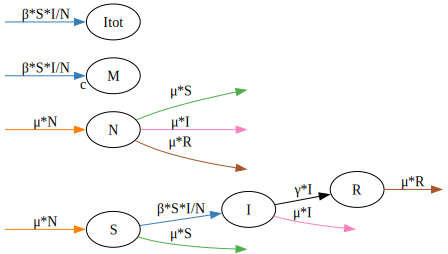

In [15]:
graph=model.get_transition_graph(show=False)
graph

The $c$ beside the arrowhead indicates that this transition occurs in steps of $c$.

## Ordinary Differential Equations

If we were not interested in stochastic dynamics, or our system cannot be visualised as a compartmental model, we might define our system via ODEs from the outset.
In general though, if a CTMC model does exist, it can be converted into a set of ODEs via:

$$\begin{aligned}
\frac{\mathrm{d} y_i}{\mathrm{d} t}=\sum_{\text{transitions, }j} \mathcal{D}_{ij}\lambda_j
\end{aligned}$$

For the current example, this results in:

$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\frac{\beta S I}{N} + \mu N - \mu S\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta S I}{N} - \gamma I - \mu I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - \mu R\\
\frac{\mathrm{d} N}{\mathrm{d} t} &= \mu N - \mu S - \mu I - \mu R = 0\\
\frac{\mathrm{d} I_{\mathrm{tot}}}{\mathrm{d} t} &= \frac{\beta S I}{N}\\
\frac{\mathrm{d} M}{\mathrm{d} t} &= \frac{c \beta S I}{N}
\end{aligned}$$

To build a PyGOM object from this, we use {class}`.Transition` classes of the type, `ODE`, and pass a list of these in the `ode` argument.

In [16]:
dSdt=Transition(transition_type='ODE', origin='S', equation='-beta*S*I/N + mu*N - mu*S')
dIdt=Transition(transition_type='ODE', origin='I', equation='beta*S*I - gamma*I - mu*I')
dRdt=Transition(transition_type='ODE', origin='R', equation='gamma*I - mu*R')
dNdt=Transition(transition_type='ODE', origin='N', equation='0')
dMdt=Transition(transition_type='ODE', origin='M', equation='beta*S*I/N')
dItotdt=Transition(transition_type='ODE', origin='Itot', equation='c*beta*S*I/N')

model_ode=SimulateOde(state=states, param=params, ode=[dSdt, dIdt, dRdt, dNdt, dMdt, dItotdt])

In choosing this path, we have closed the door on the possibility of stochastic simulations.
For instance, PyGOM now cannot derive a state change matrix

In [17]:
model_ode.get_StateChangeMatrix()

Matrix(6, 0, [])

The transition graph is also not very informative.
We are basically provided with our set of ODEs with some adorning arrows (which are also dashed, as we see below this is useful to differentiate between deterministic and stochastic processes).

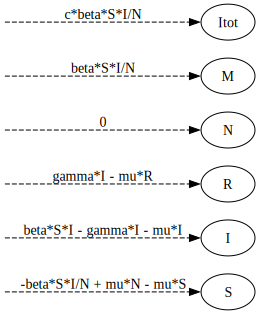

In [18]:
graph=model_ode.get_transition_graph(show=False)
graph

## Combining ODEs and Transitions

There could be cases where our system contains both stochastic and deterministic elements.
In our current example, each infection costs $c$ monetary units.
We could imagine this to be associated with one-off acute costs of the infection event such as a diagnostic test.
However, the symptoms which follow infection may introduce additional costs, say, $d$ units per person per day, perhaps due to treatment or money lost due to days not worked.

These latter kind of effects we have just seen how to deal with, by using {class}`.Transition` objects of the type `ODE`.
It is then trivial to combine these, by using both the `event` and `ode` arguments of {class}`.SimulateOde`.
In doing so below, we will also learn how to build on a previously created model.
We add any new parameters to the model `param_list` and our ODEs to the `ode` attribute:

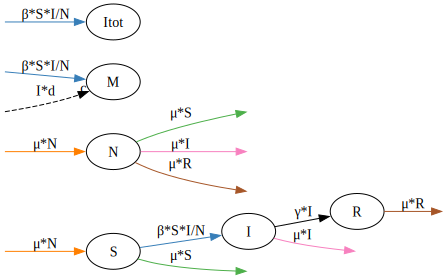

In [19]:
disease_cost=Transition(origin="M", equation="I*d", transition_type="ODE")

model.param_list=model.param_list+['d']
model.ode_list=[disease_cost]

graph=model.get_transition_graph(show=False)
graph

where the deterministic transition is indicated by a dashed line type.
The $c$ magnitude indicator next to the blue arrowhead looks like it could instead be associated with the dashed arrowhead, so care needs to be taken when interpreting these graphs until this feature has been optimised.

## ODE vs Event definition in PyGOM

PyGOM allows the user flexibility in choosing which of these perspectives to use, or indeed combine if possible, in order to build their models.
If stochastic solutions are required, however, then PyGOM *must* know the underlying transitions.
The easiest way is to supply this information directly, however, {doc}`in some cases <unroll/unrollSimple>`, it can also attempt to reverse engineer transitions if ODE's are instead supplied.
If stochastic solutions are not required (or, indeed, the system is not based on a compartmental model), then the system can be specified either in terms of ODEs or transitions (if applicable).

One advantage of specifying our system using the transition approach is that many will find transitions a more intuitive language when thinking about compartmental models.
Perhaps more beneficial, though, is that when building models with transitions using PyGOM, it enables the computer to do our book-keeping when converting transitions to ODE equations.
This reduces the error of, for example, including a flow out of one state, but forgetting to include it in the recipient state.
For example, in the case above, when indicating infections with $-\frac{\beta SI}{N}$ in the $\frac{\mathrm{d}S}{\mathrm{d}t}$ equation, we had to remember to include the opposite sign in the $\frac{\mathrm{d}I}{\mathrm{d}t}$ equation.